In [1]:
# A notebook for training a policy based agent using episodes playing a virtual game
import sys, random, os, math, time, itertools
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../app')
from config import Config

%matplotlib inline

In [19]:
class Policy:
    def __init__(self):
        self.high_level_actions = [
            'wait', #if stunned
            'random', #a valid strategy
           'go_opponent_flag',  #go get the flag
           'go_team_flag_area',  #especially if you have the flag
           'go_opponent_flag_carrier', #tag flag carrier
           'go_nearest_opponent', #chase
           'go_nearest_teammate', #a good choice if you have the flag
           'go_nearest_incapacitated_teammate', #revive them
           'gaurd_nearest_teammate',  #get between nearest teammate and enemy
           'gaurd_teammate_flag_carrier', #get between flag carrying teammate and enemy
           'gaurd_team_flag_area', #get between flag area and enemy
           'guard_opponent_flag_area',  #especially if opponent is running the flag
           'run_away_from_nearest_opponent',  #if being chased
           'run_away_from_opponents_centroid' #allows skirting dangerous areas
          ]
        
        self.high_level_states = ['opponents_flag_in_play', 
                                  'team_flag_in_play', 
                                  'self_incapacitated', 
                                  'self_has_flag', 
                                  'self_in_enemy_territory',
                                  'nearest_teammate_has_flag',
                                  'nearest_teammate_incapacitated', 
                                  'nearest_opponent_has_flag',
                                  'nearest_opponent_incapacitated'
                                 ]
        
        self.high_level_state_codes = [tuple([int(s) for s in seq]) for seq in itertools.product('01', repeat=len(self.high_level_states))]
        
        self.q = np.zeros((len(self.high_level_state_codes), len(self.high_level_actions)))
        
        
    def get_high_level_action(self, player, the_map):
        '''Get a high level action for the player based on high level percepts'''
        #this should only be called for live players, not incapacitated players, but we'll check
        if player.is_incapacitated:
            return 'wait'
        
        #Create high level state from percept derived from player and map state
        high_level_state = self.get_high_level_state(player, the_map)
        state_idx = self.high_level_state_codes.index(high_level_state)
        
        #select best action with probability proportional to utility
        action_utilities = {}
        
        #hla = high level action
        for hla in self.get_available_hlas(player, the_map, high_level_state):
            action_idx = self.high_level_actions.index(hla)
            value = self.q[state_idx, action_idx]
            action_utilities[hla] = value
        
        actions = [k for k in action_utilities.keys()]
        scale = sum(action_utilities.values())
        probs = [v/scale for v in action_utilities.values()]
        
        idx = np.random.choice(len(actions), p=probs)
        
        return actions[idx]
    
    
    def get_high_level_state(self, player, the_map):
        '''Determine which high level state applies at this time'''
        state = [0 for i in range(len(self.high_level_states))]
        
        #if player is incapacitated, that is all that matters, this saves making pointless states
        if player.is_incapacitated:
            state[self.high_level_states.index('self_incapacitated')] = 1   
            return tuple(state)
        
        if (player.team=='blue' and the_map.red_flag_in_play) or (player.team=='red' and the_map.blue_flag_in_play):
            state[self.high_level_states.index('opponents_flag_in_play')] = 1
        if (player.team=='blue' and the_map.blue_flag_in_play) or (player.team=='red' and the_map.red_flag_in_play):
            state[self.high_level_states.index('team_flag_in_play')] = 1
        if player.has_flag:
            state[self.high_level_states.index('self_has_flag')] = 1
        if player.in_enemy_territory:
            state[self.high_level_states.index('self_in_enemy_territory')] = 1
            
        teammate_player = the_map.get_closest_player_by_team(player, player.team)
        if teammate_player.has_flag:
            state[self.high_level_states.index('nearest_teammate_has_flag')] = 1
        if teammate_player.is_incapacitated:
            state[self.high_level_states.index('nearest_teammate_incapacitated')] = 1
        
        opponent_player = the_map.get_closest_player_by_team(player, 'red' if player.team=='blue' else 'blue')
        if opponent_player.has_flag:
            state[self.high_level_states.index('nearest_opponent_has_flag')] = 1
        if opponent_player.is_incapacitated:
            state[self.high_level_states.index('nearest_opponent_incapacitated')] = 1
            
        return tuple(state)
            
        
    def get_available_hlas(self, player, the_map, high_level_state):
        '''Determine possible high level actions given the high level state'''
        #almost all hlas are possible except the two dependent on the flag being carried
        if player.is_incapacitated:
            return ['wait']
        
        hlas = self.high_level_actions.copy()
        hlas.remove('go_opponent_flag_carrier')
        hlas.remove('gaurd_teammate_flag_carrier')
        hlas.remove('go_nearest_incapacitated_teammate')
        
        if (player.team=='blue' and the_map.blue_flag_in_play) or (player.team=='red' and not the_map.red_flag_in_play):
            hlas.append('go_opponent_flag_carrier')
        if (player.team=='blue' and the_map.red_flag_in_play) or (player.team=='red' and not the_map.blue_flag_in_play):
            hlas.append('gaurd_teammate_flag_carrier')
        if high_level_state[self.high_level_states.index('nearest_teammate_incapacitated')]==1:
            hlas.append('go_nearest_incapacitated_teammate')
            
        return hlas

In [24]:
class VirtualMap():
    def __init__(self, config):
        self.players = []
        
        self.tile_speeds = np.load(config.map_default_speed_array)
        idx = np.where(self.tile_speeds==0)
        self.not_allowed = list(zip(idx[0].tolist(), idx[1].tolist()))
        self.middle_tile = self.tile_speeds.shape[1]//2
        
        #flags
        blue_flag_x = 5
        col_speeds = self.tile_speeds[:, blue_flag_x]
        idx = np.where(col_speeds > 0)[0].tolist()
        blue_flag_y = random.choice(idx[2:-2])
        self.blue_flag_xy = (blue_flag_x, blue_flag_y)
        if config.verbose:
            print('blue flag xy', self.blue_flag_xy)
        
        red_flag_x = self.tile_speeds.shape[1] - blue_flag_x
        col_speeds = self.tile_speeds[:, red_flag_x]
        idx = np.where(col_speeds > 0)[0].tolist()
        red_flag_y = random.choice(idx[2:-2])
        self.red_flag_xy = (red_flag_x, red_flag_y)
        if config.verbose:
            print('red flag xy', self.red_flag_xy)
        
        self.blue_flag_area = [(x,y) for x in range(self.blue_flag_xy[0]-2, self.blue_flag_xy[0]+3) for y in range(self.blue_flag_xy[1]-2, self.blue_flag_xy[1]+3)]
        self.red_flag_area = [(x,y) for x in range(self.red_flag_xy[0]-2, self.red_flag_xy[0]+3) for y in range(self.red_flag_xy[1]-2, self.red_flag_xy[1]+3)]
        self.blue_flag_in_play = False
        self.red_flag_in_play = False
        
        
    def get_closest_player_by_team(self, player, team):
        best_dist=float('inf')
        best_player = None
        x1, y1 = player.xy
        
        for other_player in self.players:
            if other_player.player_idx==player.player_idx or not other_player.team==team:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player = other_player
                
        return best_player
    
    
    def get_closest_player_to_xy_by_team(self, player, team):
        best_dist=float('inf')
        best_player = None
        x1, y1 = player.xy
        for other_player in self.players:
            if other_player.player_idx==player.player_idx or not other_player.team==team:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player = other_player
                
        return best_player
    
    
    def get_closest_incapacitated_player_by_team(self, player, team):
        best_dist=float('inf')
        best_player = None
        x1, y1 = player.xy
        
        for other_player in self.players:
            if other_player.player_idx==player.player_idx or not other_player.team==team or not other_player.is_incapacitated:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player = other_player
                
        return best_player
    
    
    #copied from Player
    def get_direction_to_xy(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        delta_x, delta_y = x2 - x1, y2 - y1
        if abs(delta_x)>abs(delta_y):
            return 'a' if delta_x<0 else 'd'
        else:
            return 'w' if delta_y<0 else 's'
        
        
    def get_direction_away_from(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        delta_x, delta_y = x1 - x2, y1 - y2
        if abs(delta_x)<abs(delta_y):
            return 'a' if delta_x<0 else 'd'
        else:
            return 'w' if delta_y<0 else 's'
        
        
    def go_between(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        midx, midy = x1 + ((x2 - x1)/2), y1 + ((y2 - y1)/2)
        return self.get_direction_to_xy(xy1, (midx, midy))
    
        
        
class VirtualPlayer():
    def __init__(self, team, idx, the_map, xy):
        self.team = team
        self.player_idx = idx
        self.the_map = the_map
        self.has_flag = False
        self.is_incapacitated = False
        self.incapacitated_countdown = 0
        self.in_enemy_territory = False
        self.in_flag_area = False
        self.xy = xy
        self.prev_dir = random.choice(['a','w','s','d'])
        #for penalties
        self.got_tagged = False
        self.got_tagged_with_flag = False
        self.teammate_got_flag = False
        self.opponent_got_flag = False
        self.lost = False
        self.won = False
        
        
class VirtualGame():
    def __init__(self, config):
        self.verbose = config.verbose
        self.the_map = VirtualMap(config)
        team_size = config.blue_team_size
        
        #put players in the map
        side = self.the_map.tile_speeds.shape[1]//3
        for team in ['blue', 'red']:
            if team=='blue':
                idx = np.where(self.the_map.tile_speeds[:,:side]>0)
            else:
                idx = np.where(self.the_map.tile_speeds[:,(side*2):]>0)
                idx = (idx[0], idx[1] + np.ones_like(idx[1]) * (side*2))
            allowed_init_tiles = list(zip(idx[0].tolist(), idx[1].tolist()))
            random.shuffle(allowed_init_tiles)
        
            for i in range(team_size):
                y, x = allowed_init_tiles.pop()
                if self.verbose:
                    print('%s player %d at (%d, %d)' % (team, i, x, y))
                player = VirtualPlayer(team, i, self.the_map, (x, y))
                self.the_map.players.append(player)
                
        #rewards
        #movement reward is speed value - 5
        self.stationary_reward = -5
        
        self.got_tagged_reward = -10
        self.got_tagged_with_flag_reward = -50
        self.tagged_reward = 20
        self.tagged_flag_holder_reward = 50
        
        self.revived_teammate_reward = 25
        self.got_flag_reward = 50
        self.teammate_got_flag_reward = 30
        self.opponent_got_flag_reward = -30
        
        self.lost_reward = -1000
        self.won_reward = 1000
        
        if self.verbose:
            for r in range(self.the_map.tile_speeds.shape[0]):
                row=[]
                for c in range(self.the_map.tile_speeds.shape[1]):
                    s = str(self.the_map.tile_speeds[r,c])
                    if self.the_map.blue_flag_xy==(c,r):
                        s = 'BF'
                    elif self.the_map.red_flag_xy==(c,r):
                        s = 'RF'
                    for player in self.the_map.players:
                        if player.xy==(c,r):
                            s = 'B-%d' % player.player_idx if player.team=='blue' else 'R-%d' % player.player_idx
                            break
                    row.append(s)
                print(',   '.join(row))
                    
            
        
    def step(self, player, hla):
        if self.verbose:
            print('%s player %d at %s has HLA %s' % (player.team, player.player_idx, str(player.xy), hla))
            
        #execute a game step for a player using high level action and policy
        opponent_team = 'red' if player.team=='blue' else 'blue'
        
        #apply any outstanding penalties caused by another player
        if player.got_tagged:
            player.got_tagged = False
            if self.verbose:
                print('\ttagged')
            return self.got_tagged_reward, False
        elif player.got_tagged_with_flag:
            player.got_tagged_with_flag = False
            if self.verbose:
                print('\ttagged with flag')
            return self.got_tagged_with_flag_reward, False
        elif player.teammate_got_flag:
            player.teammate_got_flag = False
            if self.verbose:
                print('\tteammate got flag')
            return self.teammate_got_flag_reward, False
        elif player.opponent_got_flag:
            player.opponent_got_flag = False
            if self.verbose:
                print('\topponent got flag')
            return self.opponent_got_flag_reward, False
        elif player.lost:
            if self.verbose:
                print('\tteam lost')
            return self.lost_reward, True
        elif player.won:
            if self.verbose:
                print('\tteam won')
            return self.won_reward, True
        
        
        if player.is_incapacitated:
            player.incapacitated_countdown -= 1
            #is countdown over?
            if player.incapacitated_countdown<=0:
                if self.verbose:
                    print('\tno longer incapacitated')
                player.is_incapacitated = False
            else:
                if self.verbose:
                    print('\tstill incapacitated for %d rounds' % (player.incapacitated_countdown))
            return self.stationary_reward, False
        
        
        action = self.__hla_to_direction(player, hla)
        if self.verbose:
            print('\tlow level action %s' % (action))
                
        #apply direction if possible
        player_x, player_y = player.xy
        new_xy = player.xy
        speed = 0
        #tile speeds is row by col, which equals y by x
        if action=='w' and (player_y-1, player_x) not in self.the_map.not_allowed:
            new_xy = (player_x, player_y-1)
            speed = self.the_map.tile_speeds[player_y-1, player_x]
        elif action=='s' and (player_y+1, player_x) not in self.the_map.not_allowed:
            new_xy = (player_x, player_y+1)
            speed = self.the_map.tile_speeds[player_y+1, player_x]
        elif action=='a' and (player_y, player_x-1) not in self.the_map.not_allowed:
            new_xy = (player_x-1, player_y)
            speed = self.the_map.tile_speeds[player_y, player_x-1]
        elif action=='d' and (player_y, player_x+1) not in self.the_map.not_allowed:
            new_xy = (player_x+1, player_y)
            speed = self.the_map.tile_speeds[player_y, player_x+1]
        
        
        #if the player didn't move
        if not speed:
            if self.verbose:
                print('\tspeed is 0 at desired position')
            return self.stationary_reward, False
        
        
        #update position
        player.xy = new_xy
        if self.verbose:
            print('\tnew position: %s, speed %d' % (str(player.xy), speed))
            
        if player.team=='blue':
            if player.xy[0]>self.the_map.middle_tile and not player.in_enemy_territory:
                if self.verbose:
                    print('\tplayer entered enemy territory')
                player.in_enemy_territory=True
            elif player.xy[0]<self.the_map.middle_tile and player.in_enemy_territory:
                if self.verbose:
                    print('\tplayer exitted enemy territory')
                player.in_enemy_territory=False
        if player.team=='red':
            if player.xy[0]<self.the_map.middle_tile and not player.in_enemy_territory:
                if self.verbose:
                    print('\tplayer entered enemy territory')
                player.in_enemy_territory=True
            elif player.xy[0]>self.the_map.middle_tile and player.in_enemy_territory:
                if self.verbose:
                    print('\tplayer exitted enemy territory')
                player.in_enemy_territory=False
                
        
        #player won
        if player.team=='blue' and player.has_flag and new_xy in self.the_map.blue_flag_area:
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.lost = True
                else:
                    other_player.won = True
            #add rewards for other players AFTER the end signal is sent in order to award/penalize all players
            if self.verbose:
                print('\tplayer won')
            return self.won_reward, True
        elif player.team=='red' and player.has_flag and new_xy in self.the_map.red_flag_area:
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.lost = True
                else:
                    other_player.won = True
            if self.verbose:
                print('\tplayer won')
            return self.won_reward, True
        
        
        #player got flag
        if new_xy==self.the_map.red_flag_xy and player.team=='blue' and not self.the_map.red_flag_in_play:
            player.has_flag = True
            self.the_map.red_flag_in_play = True
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.opponent_got_flag = True
                else:
                    other_player.teammate_got_flag = True
            if self.verbose:
                print('\tplayer got flag')
            return self.got_flag_reward, False
        
        if new_xy==self.the_map.blue_flag_xy and player.team=='red' and not self.the_map.blue_flag_in_play:
            player.has_flag = True
            self.the_map.blue_flag_in_play = True
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.opponent_got_flag = True
                else:
                    other_player.teammate_got_flag = True
            if self.verbose:
                print('\tplayer got flag')
            return self.got_flag_reward, False
        
        
        #player tagged someone
        for other_player in self.the_map.players:
            #skip self
            if other_player.player_idx==player.player_idx:
                continue
                
            if not other_player.xy==new_xy:
                continue
                
            if other_player.team==opponent_team and not other_player.is_incapacitated and (other_player.in_enemy_territory or other_player.has_flag):
                other_player.is_incapacitated = True
                other_player.incapacitation_countdown = 5
                if other_player.has_flag:
                    other_player.has_flag = False
                    other_player.got_tagged_with_flag = True
                    if player.team=='blue':
                        self.the_map.red_flag_in_play = False
                    else:
                        self.the_map.blue_flag_in_play = False
                    if self.verbose:
                        print('\tplayer tagged %s-%d' % (other_player.team, other_player.player_idx))
                    return self.tagged_flag_holder_reward, False
                else:
                    other_player.got_tagged = True
                    if self.verbose:
                        print('\tplayer tagged flag carrier %s-%d' % (other_player.team, other_player.player_idx))
                    return self.tagged_reward, False
            #revived teammate?
            elif other_player.team==player.team and other_player.is_incapacitated:
                other_player.is_incapacitated = False
                other_player.incapacitation_countdown = 0
                if self.verbose:
                    print('\tplayer revived %s-%d' % (other_player.team, other_player.player_idx))
                return self.revived_teammate_reward, False
            
        #player just moved
        return speed - 5, False
    
    
    #copied from policy agent
    def __hla_to_direction(self, player, hla):
        action = ''
        team = 'blue' if player.team=='blue' else 'red'
        opponent_team = 'red' if player.team=='blue' else 'blue'
        xy1 = player.xy
        
        if hla=='wait':
            return ''
        elif hla=='random':
            if random.randint(1,20) == 1:
                player.prev_dir = random.choice(['a','w','s','d'])
            action = player.prev_dir
        elif hla=='go_opponent_flag':
            xy2 = self.the_map.red_flag_xy if team=='blue' else self.the_map.blue_flag_xy
            action = self.the_map.get_direction_to_xy(xy1, xy2)
        elif hla=='go_team_flag_area':
            xy2 = self.the_map.blue_flag_xy if team=='blue' else self.the_map.red_flag_xy
            action = self.the_map.get_direction_to_xy(xy1, xy2)
        elif hla=='go_opponent_flag_carrier':
            for other_player in self.the_map.players:
                if not (other_player.team==opponent_team and other_player.has_flag):
                    continue
                action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
                break
        elif hla=='go_nearest_opponent':
            other_player = self.the_map.get_closest_player_by_team(player, opponent_team)
            action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
        elif hla=='go_nearest_teammate':
            other_player = self.the_map.get_closest_player_by_team(player, team)
            action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
        elif hla=='go_nearest_incapacitated_teammate':
            other_player = self.the_map.get_closest_incapacitated_player_by_team(player, team)
            action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
        elif hla=='gaurd_nearest_teammate':
            other_player = self.the_map.get_closest_player_by_team(player, team)
            opponent_player = self.the_map.get_closest_player_to_xy_by_team(player, opponent_team)
            action = self.the_map.go_between(other_player.xy, opponent_player.xy)
        elif hla=='gaurd_teammate_flag_carrier':
            for other_player in self.the_map.players:
                if not (other_player.team==player.team and other_player.has_flag):
                    continue
                opponent_player = self.the_map.get_closest_player_to_xy_by_team(player, opponent_team)
                action = self.the_map.get_direction_to_xy(opponent_player.xy, other_player.xy)
                break
        elif hla=='gaurd_team_flag_area':
            xy2 = self.the_map.blue_flag_xy if team=='blue' else self.the_map.red_flag_xy
            other_player = self.the_map.get_closest_player_to_xy_by_team(player, opponent_team)
            action = self.the_map.go_between(other_player.xy, xy2)
        elif hla=='guard_opponent_flag_area':
            xy2 = self.the_map.red_flag_xy if team=='blue' else self.the_map.blue_flag_xy
            other_player = self.the_map.get_closest_player_to_xy_by_team(player, opponent_team)
            action = self.the_map.go_between(other_player.xy, xy2)
        elif hla=='run_away_from_nearest_opponent':
            other_player = self.the_map.get_closest_player_by_team(player, opponent_team)
            action = self.the_map.get_direction_away_from(xy1, other_player.xy)
        elif hla=='run_away_from_opponents_centroid':
            xs, ys = [],[]
            for other_player in self.the_map.players:
                if not other_player.team==opponent_team:
                    continue
                xs.append(other_player.xy[0])
                ys.append(other_player.xy[1])
            mean_xy = (sum(xs)/len(xs), sum(ys)/len(ys))
            action = self.the_map.get_direction_away_from(xy1, mean_xy)
            
        return action

In [25]:
policy = Policy()
config = Config(verbose=True)
config.blue_team_size = 2
config.red_team_size = 2
game = VirtualGame(config)
player_prev_state_action = {'%s-%d' % (p.team, p.player_idx):(None,None) for p in game.the_map.players}
state_cts = {}
game_over = False
skip_team_idx = ()
final_scores = False
        
for i in range(100):
    print('\n\nStep %d' % i)
    for player in game.the_map.players:
        if game_over and skip_team_idx and skip_team_idx==(player.team, player.player_idx):
            final_scores = True
            continue
                        
        idx = '%s-%d' % (player.team, player.player_idx)
        prev_state, prev_action = player_prev_state_action[idx]

        state = policy.get_high_level_state(player, game.the_map)

        if state==prev_state:
            action = prev_action
        else:
            action = random.choice(policy.get_available_hlas(player, game.the_map, state))
            player_prev_state_action[idx] = (state, action)
            
            print('\nHigh level state:')
            for j in range(len(state)):
                if state[j]:
                    print('   %s' % policy.high_level_states[j])
                    
            if not state in state_cts:
                state_cts[state]=0
            state_cts[state]+=1

        reward, game_over = game.step(player, action)
        print('Reward: %d, Game over: %s' % (reward, game_over))
        
        new_state = policy.get_high_level_state(player, game.the_map)
        if not new_state==state:
            print('New high level state')
            
        if game_over:
            if not skip_team_idx:
                skip_team_idx=(player.team, player.player_idx)
                break
            
    if game_over and final_scores:
        break

print('\n\n\n')
for st,ct in state_cts.items():
    print(st, ct)

blue flag xy (5, 28)
red flag xy (37, 8)
blue player 0 at (2, 25)
blue player 1 at (4, 6)
red player 0 at (38, 20)
red player 1 at (38, 12)
0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0
0.0,   10.0,   4.0,   4.0,   4.0,   10.0,   4.0,   10.0,   10.0,   10.0,   10.0,   10.0,   10.0,   10.0,   4.0,   4.0,   4.0,   4.0,   10.0,   10.0,   10.0,   10.0,   10.0,   7.0,   7.0,   0.0,   7.0,   10.0,   10.0,   10.0,   7.0,   10.0,   10.0,   10.0,   10.0,   4.0,   7.0,   7.0,   7.0,   7.0,   7.0,   0.0
0.0,   10.0,   4.0,   4.0,   4.0,   4.0,   4.0,   4.0,   4.0,   4.0,   10.0,   10.0,   10.0,   4.0,   4.0,   4.0,   4.0,   4.0,   4.0,   7.0,   10.0,   10.0,   10.0,   7.0,   0.0,   0.0,   7.0,   7.0,   10.0,   10.0,   10.0,   10.0,   10.0,   10.0,   10.0, 

	speed is 0 at desired position
Reward: -5, Game over: False


Step 42
blue player 0 at (20, 29) has HLA wait
	low level action 
	speed is 0 at desired position
Reward: -5, Game over: False
blue player 1 at (10, 1) has HLA random
	low level action s
	new position: (10, 2), speed 10
Reward: 5, Game over: False
red player 0 at (38, 20) has HLA wait
	low level action 
	speed is 0 at desired position
Reward: -5, Game over: False
red player 1 at (40, 1) has HLA run_away_from_nearest_opponent
	low level action d
	speed is 0 at desired position
Reward: -5, Game over: False


Step 43
blue player 0 at (20, 29) has HLA wait
	low level action 
	speed is 0 at desired position
Reward: -5, Game over: False
blue player 1 at (10, 2) has HLA random
	low level action s
	new position: (10, 3), speed 10
Reward: 5, Game over: False
red player 0 at (38, 20) has HLA wait
	low level action 
	speed is 0 at desired position
Reward: -5, Game over: False
red player 1 at (40, 1) has HLA run_away_from_nearest_oppon

red player 1 at (40, 1) has HLA run_away_from_nearest_opponent
	low level action d
	speed is 0 at desired position
Reward: -5, Game over: False


Step 88
blue player 0 at (20, 29) has HLA wait
	low level action 
	speed is 0 at desired position
Reward: -5, Game over: False
blue player 1 at (15, 1) has HLA random
	low level action w
	speed is 0 at desired position
Reward: -5, Game over: False
red player 0 at (38, 20) has HLA wait
	low level action 
	speed is 0 at desired position
Reward: -5, Game over: False
red player 1 at (40, 1) has HLA run_away_from_nearest_opponent
	low level action d
	speed is 0 at desired position
Reward: -5, Game over: False


Step 89
blue player 0 at (20, 29) has HLA wait
	low level action 
	speed is 0 at desired position
Reward: -5, Game over: False
blue player 1 at (15, 1) has HLA random
	low level action w
	speed is 0 at desired position
Reward: -5, Game over: False
red player 0 at (38, 20) has HLA wait
	low level action 
	speed is 0 at desired position
Rewar

In [27]:
state_to_monitor = (1,0,0,1,0,0,0,0,0) #''opponents_flag_in_play, 'self_has_flag'

In [30]:
class PolicyTrainer():
    def __init__(self, policy, config):
        self.policy = policy
        self.config = config
        self.discount = 0.8
        self.alpha = 1.0
        self.episodes = 1000
        
        
    def train(self):
        deltas = []
        ep_deltas = []
        state_cts = {}
        state_to_monitor = (1,0,0,1,0,0,0,0,0) #''opponents_flag_in_play, 'self_has_flag'
        monitor_idx = policy.high_level_state_codes.index(state_to_monitor)
        
        #each episode
        for i in range(self.episodes):
            if i and i%10==0:        
                deltas.append(sum(ep_deltas)/len(ep_deltas))  
                ep_deltas = []
                
            if i and i%50==0:
                print('episode', i)
                for j in range(len(self.policy.high_level_actions)):
                    print('%s\t\t\t%.4f' % (self.policy.high_level_actions[j], self.policy.q[monitor_idx,j]))
                self.__plot(deltas)
                np.save('q.npy', self.policy.q)
                with open('state_counts.txt', 'w') as o:
                    o.write('%s\n' % '\t'.join(self.policy.high_level_states))
                    for st,ct in state_cts.items():
                        o.write('%s\t%d\n' % ('\t'.join([str(s) for s in st]), ct))
                
            #create virtual game, map, and players
            game = VirtualGame(self.config)
            
            #when game is over, do one more pass over players, skipping the person who won the game and was rewarded
            game_over = False
            skip_team_idx = ()
            final_scores = False
            
            #track if the state has changed for a player and only choose new HLA then
            player_prev_state_action = {'%s_%d' % (p.team, p.player_idx):(None,None) for p in game.the_map.players}
            
            for j in range(2000): #cut game off after x steps
                random.shuffle(game.the_map.players)
                for player in game.the_map.players:
                    idx = '%s_%d' % (player.team, player.player_idx)
                    prev_state, prev_action = player_prev_state_action[idx]
                    
                    if game_over and skip_team_idx and skip_team_idx==(player.team, player.player_idx):
                        #flag that we're assigning final scores
                        final_scores = True
                        continue
                        
                    #get game state for this player
                    state = self.policy.get_high_level_state(player, game.the_map)
                
                    if not state in state_cts:
                        state_cts[state]=0
                    state_cts[state]+=1
                
                    #only choose new action if state has changed for this player
                    if state==prev_state:
                        action = prev_action
                    else:
                        #explore actions: For each state, select any one among all possible actions for the current state (S).
                        action = random.choice(self.policy.get_available_hlas(player, game.the_map, state))
                        #update player state, action
                        player_prev_state_action[idx] = (state, action)

                    #execute the hla and get the immediate reward for the new state
                    reward, game_over = game.step(player, action)
                    
                    #Travel to the next state (S') as a result of that action (a).
                    new_state = self.policy.get_high_level_state(player, game.the_map)

                    #For all possible actions from the state (S') select the one with the highest Q-value.
                    best_action = ''
                    best_value = -float('inf')
                    for pos_action in self.policy.get_available_hlas(player, game.the_map, new_state):
                        new_state_idx = self.policy.high_level_state_codes.index(new_state)
                        pos_action_idx = self.policy.high_level_actions.index(pos_action)
                        value = self.policy.q[new_state_idx, pos_action_idx]
                        if value>best_value:
                            best_action = pos_action
                            best_value = value

                    #get previous Q value for computing delta
                    state_idx = self.policy.high_level_state_codes.index(state)
                    action_idx = self.policy.high_level_actions.index(action)
                    prev_val = self.policy.q[state_idx, action_idx]

                    #calculate the utility
                    utility = (1 - self.alpha)* prev_val + self.alpha*(reward + self.discount*best_value)
                    self.policy.q[state_idx, action_idx] = utility

                    #store the delta for plotting
                    ep_deltas.append(abs(self.policy.q[state_idx, action_idx] - prev_val))

                    #Set the next state as the current state.
                    state = new_state

                    #If goal state is reached, then end and repeat the process.
                    if game_over:
                        if not skip_team_idx:
                            skip_team_idx=(player.team, player.player_idx)
                            break
                
                #has the last pass to assign final scores occurred?
                if game_over and final_scores:
                    print('game completed at', j)
                    break
            
        print(len(state_cts))
        for st,ct in state_cts.items():
            print(st, ct)
        self.__plot(deltas)
        
        
    def __plot(self, x, path=''):
        fig, ax = plt.subplots()
        ax.plot(x)
        ax.set(xlabel='time', ylabel='q delta', title='Q Learning deltas')
        ax.grid()
        if path:
            fig.savefig(path)
        plt.show()

episode 50
wait			0.0000
random			0.0000
go_opponent_flag			29.3674
go_team_flag_area			12.8392
go_opponent_flag_carrier			0.0000
go_nearest_opponent			21.6000
go_nearest_teammate			31.8240
go_nearest_incapacitated_teammate			0.0000
gaurd_nearest_teammate			0.0000
gaurd_teammate_flag_carrier			12.8392
gaurd_team_flag_area			30.4592
guard_opponent_flag_area			0.0000
run_away_from_nearest_opponent			0.0000
run_away_from_opponents_centroid			0.0000


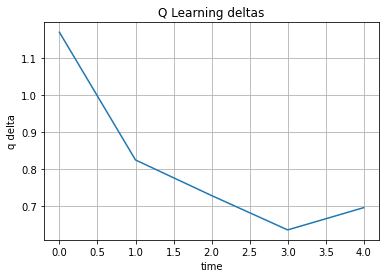

game completed at 774
game completed at 173


In [ ]:
trainer = PolicyTrainer(Policy(), Config())
trainer.train()

In [12]:
p = Policy()
q = np.load('q.npy')

In [17]:
len(p.high_level_state_codes[0])

9

In [18]:
print(q.shape)
for i in range(q.shape[0]):
    print('\n')
    hls = []
    for j in range(len(p.high_level_states)):
        #print(i,j)
        if p.high_level_state_codes[i][j]:
            hls.append(p.high_level_states[j])
            
    print(', '.join(hls))
    
    if np.sum(q[i,:])==0:
        print('\tstate never reached')
    else:
        for j in range(len(p.high_level_actions)):
            print('\t%s\t\t\t%.4f' % (p.high_level_actions[j], q[i,j]))

(512, 14)



	wait			299.7902
	random			380.9877
	go_opponent_flag			380.9877
	go_team_flag_area			303.7902
	go_opponent_flag_carrier			299.7902
	go_nearest_opponent			380.9877
	go_nearest_teammate			303.7902
	go_nearest_incapacitated_teammate			0.0000
	gaurd_nearest_teammate			377.9877
	gaurd_teammate_flag_carrier			299.7902
	gaurd_team_flag_area			299.7902
	guard_opponent_flag_area			301.7902
	run_away_from_nearest_opponent			299.7902
	run_away_from_opponents_centroid			299.7902


nearest_opponent_incapacitated
	wait			17.8159
	random			25.4159
	go_opponent_flag			21.8159
	go_team_flag_area			25.5198
	go_opponent_flag_carrier			18.5198
	go_nearest_opponent			22.5198
	go_nearest_teammate			24.8159
	go_nearest_incapacitated_teammate			0.0000
	gaurd_nearest_teammate			18.5198
	gaurd_teammate_flag_carrier			17.8159
	gaurd_team_flag_area			25.5198
	guard_opponent_flag_area			22.5198
	run_away_from_nearest_opponent			22.5198
	run_away_from_opponents_centroid			18.5198


nearest_opponent_ha


team_flag_in_play	self_has_flag	nearest_teammate_incapacitated	nearest_opponent_has_flag
	state never reached


team_flag_in_play	self_has_flag	nearest_teammate_incapacitated	nearest_opponent_has_flag	nearest_opponent_incapacitated
	state never reached


team_flag_in_play	self_has_flag	nearest_teammate_has_flag
	state never reached


team_flag_in_play	self_has_flag	nearest_teammate_has_flag	nearest_opponent_incapacitated
	state never reached


team_flag_in_play	self_has_flag	nearest_teammate_has_flag	nearest_opponent_has_flag
	state never reached


team_flag_in_play	self_has_flag	nearest_teammate_has_flag	nearest_opponent_has_flag	nearest_opponent_incapacitated
	state never reached


team_flag_in_play	self_has_flag	nearest_teammate_has_flag	nearest_teammate_incapacitated
	state never reached


team_flag_in_play	self_has_flag	nearest_teammate_has_flag	nearest_teammate_incapacitated	nearest_opponent_incapacitated
	state never reached


team_flag_in_play	self_has_flag	nearest_teammate_ha



opponents_flag_in_play	self_has_flag	self_in_enemy_territory	nearest_teammate_incapacitated
	wait			306.0641
	random			306.0641
	go_opponent_flag			303.6641
	go_team_flag_area			164.5310
	go_opponent_flag_carrier			247.4547
	go_nearest_opponent			305.0641
	go_nearest_teammate			210.9638
	go_nearest_incapacitated_teammate			313.0641
	gaurd_nearest_teammate			378.8302
	gaurd_teammate_flag_carrier			306.0641
	gaurd_team_flag_area			310.0641
	guard_opponent_flag_area			305.0641
	run_away_from_nearest_opponent			313.0641
	run_away_from_opponents_centroid			310.0641


opponents_flag_in_play	self_has_flag	self_in_enemy_territory	nearest_teammate_incapacitated	nearest_opponent_incapacitated
	wait			-5.0000
	random			0.0000
	go_opponent_flag			12.2000
	go_team_flag_area			3.6000
	go_opponent_flag_carrier			0.0000
	go_nearest_opponent			0.0000
	go_nearest_teammate			0.0000
	go_nearest_incapacitated_teammate			18.4464
	gaurd_nearest_teammate			9.0000
	gaurd_teammate_flag_carrier			0.0000
	gaurd

opponents_flag_in_play	team_flag_in_play	self_has_flag	nearest_teammate_has_flag	nearest_opponent_incapacitated
	wait			32.9599
	random			21.0154
	go_opponent_flag			0.0000
	go_team_flag_area			21.8123
	go_opponent_flag_carrier			0.0000
	go_nearest_opponent			47.4499
	go_nearest_teammate			15.7741
	go_nearest_incapacitated_teammate			0.0000
	gaurd_nearest_teammate			16.9599
	gaurd_teammate_flag_carrier			36.9599
	gaurd_team_flag_area			11.0154
	guard_opponent_flag_area			11.0154
	run_away_from_nearest_opponent			0.0000
	run_away_from_opponents_centroid			0.0000


opponents_flag_in_play	team_flag_in_play	self_has_flag	nearest_teammate_has_flag	nearest_opponent_has_flag
	state never reached


opponents_flag_in_play	team_flag_in_play	self_has_flag	nearest_teammate_has_flag	nearest_opponent_has_flag	nearest_opponent_incapacitated
	state never reached


opponents_flag_in_play	team_flag_in_play	self_has_flag	nearest_teammate_has_flag	nearest_teammate_incapacitated
	state never reached


oppo